# Predicting prices for house listings

In [2]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

## Data Retrieval

We begin by retrieving our car dataset which is found in a csv file

In [5]:
house_listing_data = pd.read_csv("./house_listings.csv")

# set seed for reproducibility
np.random.seed(0)

In [6]:
house_listing_data.head()

,category,price,currency,price_1m2,title,address,floor,area,title_deed,repair,mortgage,url,room_number
0,Köhnə tikili,137 000,AZN,2 630 AZN/m²,"Satılır 3 otaqlı köhnə tikili 52 m², 8-ci kilo...",Elşən Süleymanov küç 137,7 / 9,52 m²,var,var,NaN,https://bina.az/items/3858477,3.0
1,Yeni tikili,183 000,AZN,1 790 AZN/m²,"Satılır 2 otaqlı yeni tikili 102 m², Neftçilər m.",Mehdi Abbasov küçəsi,2 / 17,102 m²,yoxdur,var,NaN,https://bina.az/items/3858493,2.0
2,Köhnə tikili,145 000,AZN,2 230 AZN/m²,"Satılır 2 otaqlı köhnə tikili 65 m², Nərimanov r.",Atatürk Prospekti,6 / 9,65 m²,var,var,var,https://bina.az/items/3858489,2.0
3,Köhnə tikili,190 000,AZN,2 000 AZN/m²,"Satılır 3 otaqlı köhnə tikili 95 m², Gənclik m.",Atatürk pr.,4 / 9,95 m²,var,var,var,https://bina.az/items/3858491,3.0
4,Yeni tikili,294 000,AZN,1 550 AZN/m²,"Satılır 3 otaqlı yeni tikili 190 m², Nəsimi r.",Möhsün Sənani küçəsi,6 / 16,190 m²,var,yoxdur,NaN,https://bina.az/items/3858488,3.0


In [7]:
house_listing_data.shape

(35503, 13)

In [8]:
house_listing_data.dtypes

category        object
price           object
currency        object
price_1m2       object
title           object
address         object
floor           object
area            object
title_deed      object
repair          object
mortgage        object
url             object
room_number    float64
dtype: object

## Data Preprocessing and Cleaning

Looking at the data we can see we have some missing data with `NaN` values and some data which need cleaning like `price_1m2`. So, let's get more information about these missing data.

#### Understanding issues in our data

In [12]:
# get the number of missing data points per column
missing_values_count = house_listing_data.isnull().sum()

# look at the # of missing points in the first thirteen columns
missing_values_count[0:13]

category          37
price             37
currency          37
price_1m2         37
title             37
address           37
floor             37
area              37
title_deed        37
repair          1729
mortgage       23861
url                0
room_number       37
dtype: int64

That looks like a lot! Let's look at what percentage of the values in our dataset were missing to give us a better sense of the scale of this problem

In [14]:
# how many total missing values do we have?
total_cells = np.product(house_listing_data.shape)
total_missing = missing_values_count.sum()

# percent of data that is missing
percent_missing = (total_missing/total_cells) * 100
print(percent_missing)

5.624660104563212


We want to ensure that number of empty rows isn't fully empty for all 37 rows since 37 is occuring a lot in our above missing value count. If it is, we will drop those rows

In [16]:
num_empty_rows = house_listing_data.isnull().all(axis=1).sum()
print(f"Number of fully empty rows: {num_empty_rows}")

Number of fully empty rows: 0


Only ~5% of the cells in this dataset are empty! In the next step, we're going to take a closer look at some of the columns with missing values and try to figure out what might be going on with them.

In [18]:
# How many distinct values per column
for column in house_listing_data.columns:
    distinct_values = house_listing_data[column].unique()
    print(f"{column} has {len(distinct_values)} values.")

category has 3 values.
price has 1832 values.
currency has 2 values.
price_1m2 has 706 values.
title has 10941 values.
address has 10046 values.
floor has 383 values.
area has 1116 values.
title_deed has 3 values.
repair has 3 values.
mortgage has 2 values.
url has 35503 values.
room_number has 15 values.


#### Cleaning ideas

We see some features have discrete, categorical, and continuous values. We will handle each feature using `imputation` and `default values` where needed.

Let's begin by handling categorical and discrete values

* We see `category`, `currency`, `title_deed`, `repair`, `mortgage` have just 3, 2, 3, 3, and 2 unique values respectively. They're categorical, so we can use `mode imputation`.
* `floor` though has 383 values, it is of the form `floor/total_floor`. It seems discrete as a whole, we see a total number of floors for each building which makes things difficult to handle. For this, we could either have three columns `apartment_floor`, `building_floors`, and `floor_ratio` which will determine how high the apartment is.
* We see `room_number` is discrete, so we can use `mode imputation`.

For our continous values [`price`, `price_1m2`, `area`], we will simply use `median imputation`. We also notice that price_1m2 and area need further cleaning since they have $AZN/m^2$ and $m^2$ respectively in their data.

We can also see that we have some text data like `title` and `address`. We can't really consider these categorical or discrete since they are quite a lot and can probably be anything. Here, we simply use a `default value` on it. I would have said let's predict it but that will require text mining which is out of scope in our research.

#### Cleaning

Let us begin cleaning, we start with `mode imputation`. We want to impute category, currency, title_deed, repair, mortgage, and room number, so we should extract these part of the dataframe and impute before combining.

In [27]:
mode_features = ["category", "currency", "title_deed", "repair", "mortgage", "room_number"]
mode_data = house_listing_data[mode_features]
mode_data.head()

,category,currency,title_deed,repair,mortgage,room_number
0,Köhnə tikili,AZN,var,var,NaN,3.0
1,Yeni tikili,AZN,yoxdur,var,NaN,2.0
2,Köhnə tikili,AZN,var,var,var,2.0
3,Köhnə tikili,AZN,var,var,var,3.0
4,Yeni tikili,AZN,var,yoxdur,NaN,3.0


In [28]:
from sklearn.impute import SimpleImputer

In [29]:
mode_imputer = SimpleImputer(strategy='most_frequent') # most_frequent for mode
imputed_mode = pd.DataFrame(mode_imputer.fit_transform(mode_data))

# Imputation removed column names; so we put them back
imputed_mode.columns = mode_features

imputed_mode.head()

,category,currency,title_deed,repair,mortgage,room_number
0,Köhnə tikili,AZN,var,var,var,3.0
1,Yeni tikili,AZN,yoxdur,var,var,2.0
2,Köhnə tikili,AZN,var,var,var,2.0
3,Köhnə tikili,AZN,var,var,var,3.0
4,Yeni tikili,AZN,var,yoxdur,var,3.0


In [30]:
imputed_mode.isnull().sum() # verify if any null value

category       0
currency       0
title_deed     0
repair         0
mortgage       0
room_number    0
dtype: int64

Let's look at imputing our continous values `price`, `price_1m2`, `area`. We first need to clean price_1m2 and area before we begin imputation.

In [32]:
median_features = ["price", "price_1m2", "area"]
median_data = house_listing_data[median_features]
median_data.head()

,price,price_1m2,area
0,137 000,2 630 AZN/m²,52 m²
1,183 000,1 790 AZN/m²,102 m²
2,145 000,2 230 AZN/m²,65 m²
3,190 000,2 000 AZN/m²,95 m²
4,294 000,1 550 AZN/m²,190 m²


In [33]:
median_data.dtypes

price        object
price_1m2    object
area         object
dtype: object

In [34]:
median_data.loc[:, "area"] = median_data["area"].astype(str).str.replace("m²", "", regex=True).str.strip().astype(float)
median_data.head()

,price,price_1m2,area
0,137 000,2 630 AZN/m²,52.0
1,183 000,1 790 AZN/m²,102.0
2,145 000,2 230 AZN/m²,65.0
3,190 000,2 000 AZN/m²,95.0
4,294 000,1 550 AZN/m²,190.0


In [35]:
median_data.loc[:, "price_1m2"] = median_data["price_1m2"].astype(str).str.replace("AZN/m²", "", regex=True).str.replace(" ", "").astype(float)
median_data.head()

,price,price_1m2,area
0,137 000,2630.0,52.0
1,183 000,1790.0,102.0
2,145 000,2230.0,65.0
3,190 000,2000.0,95.0
4,294 000,1550.0,190.0


We can see price has a whitespace inbetween the values and not a float value, so we fix this.

In [37]:
median_data.loc[:, "price"] = median_data["price"].astype(str).str.replace(" ", "").astype(float)
median_data.head()

,price,price_1m2,area
0,137000.0,2630.0,52.0
1,183000.0,1790.0,102.0
2,145000.0,2230.0,65.0
3,190000.0,2000.0,95.0
4,294000.0,1550.0,190.0


Let's impute the data now

In [39]:
median_imputer = SimpleImputer(strategy='median') # most_frequent for mode
imputed_median = pd.DataFrame(median_imputer.fit_transform(median_data))

# Imputation removed column names; so we put them back
imputed_median.columns = median_features

imputed_median.head()

,price,price_1m2,area
0,137000.0,2630.0,52.0
1,183000.0,1790.0,102.0
2,145000.0,2230.0,65.0
3,190000.0,2000.0,95.0
4,294000.0,1550.0,190.0


In [40]:
imputed_median.isnull().sum() # verify if any null value

price        0
price_1m2    0
area         0
dtype: int64

Let's clean `title` and `address`. We won't do much here but simply fill all with default value. Here we need to use a text which sounds interesting.

In [42]:
text_features = ["title", "address"]
text_data = house_listing_data[text_features]
text_data.head()

,title,address
0,"Satılır 3 otaqlı köhnə tikili 52 m², 8-ci kilo...",Elşən Süleymanov küç 137
1,"Satılır 2 otaqlı yeni tikili 102 m², Neftçilər m.",Mehdi Abbasov küçəsi
2,"Satılır 2 otaqlı köhnə tikili 65 m², Nərimanov r.",Atatürk Prospekti
3,"Satılır 3 otaqlı köhnə tikili 95 m², Gənclik m.",Atatürk pr.
4,"Satılır 3 otaqlı yeni tikili 190 m², Nəsimi r.",Möhsün Sənani küçəsi


From the title and address, we can tell it is `Azerbaijani (Azeri)`. 
After translating the first title we get `For sale: 3-room old building, 52 m², 8th Kilometer district.`
We can see a combination of "category", "room_number" and "area" in the namings which we can use to construct meaningful texts. But like I said earlier, it is beyond the scope of this research.

In [44]:
text_data.loc[:, "title"] = text_data["title"].fillna("Məlumat yoxdur") # Information not available
text_data.loc[:, "address"]= text_data["address"].fillna("Məlumat yoxdur")
text_data.isnull().sum()

title      0
address    0
dtype: int64

Let us handle the floor using the `floor_ratio`, `apartment_floor`, and `building_floors`.

In [46]:
floor_feature = ['floor']
floor_data = house_listing_data[floor_feature]
floor_data.head()

,floor
0,7 / 9
1,2 / 17
2,6 / 9
3,4 / 9
4,6 / 16


In [47]:
# floor_data.loc[:, 'apartment_floor'] = floor_data["floor"].astype(str).str.split("/").str[0].astype(float)
# floor_data.loc[:, 'building_floors'] = floor_data["floor"].astype(str).str.split("/").str[1].astype(float)

floor_data[["apartment_floor", "building_floors"]] = (
    floor_data["floor"].astype(str)
    .str.split("/", expand=True)
    .apply(pd.to_numeric, errors="coerce")  # Converts to number while keeping NaN
)

floor_data.head()

/tmp/ipykernel_12044/1727575886.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  floor_data[["apartment_floor", "building_floors"]] = (
/tmp/ipykernel_12044/1727575886.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  floor_data[["apartment_floor", "building_floors"]] = (


,floor,apartment_floor,building_floors
0,7 / 9,7.0,9.0
1,2 / 17,2.0,17.0
2,6 / 9,6.0,9.0
3,4 / 9,4.0,9.0
4,6 / 16,6.0,16.0


In [48]:
floor_data.dtypes

floor               object
apartment_floor    float64
building_floors    float64
dtype: object

In [49]:
floor_data = floor_data.drop('floor', axis=1)

In [50]:
# Fill missing data
floor_imputer = SimpleImputer(strategy='most_frequent') # most_frequent for mode
imputed_floor = pd.DataFrame(floor_imputer.fit_transform(floor_data))

# Imputation removed column names; so we put them back
imputed_floor.columns = ['apartment_floor', 'building_floors']

imputed_floor.head()

,apartment_floor,building_floors
0,7.0,9.0
1,2.0,17.0
2,6.0,9.0
3,4.0,9.0
4,6.0,16.0


In [51]:
imputed_floor["floor_ratio"] = (imputed_floor["apartment_floor"] / imputed_floor["building_floors"]).astype(float).round(1)
imputed_floor.head()

,apartment_floor,building_floors,floor_ratio
0,7.0,9.0,0.8
1,2.0,17.0,0.1
2,6.0,9.0,0.7
3,4.0,9.0,0.4
4,6.0,16.0,0.4


#### Joining imputed/transform datasets

In [53]:
cleaned_house_listing = pd.concat([imputed_mode, imputed_median, text_data, imputed_floor, house_listing_data['url']], axis=1)
cleaned_house_listing.head()

,category,currency,title_deed,repair,mortgage,room_number,price,price_1m2,area,title,address,apartment_floor,building_floors,floor_ratio,url
0,Köhnə tikili,AZN,var,var,var,3.0,137000.0,2630.0,52.0,"Satılır 3 otaqlı köhnə tikili 52 m², 8-ci kilo...",Elşən Süleymanov küç 137,7.0,9.0,0.8,https://bina.az/items/3858477
1,Yeni tikili,AZN,yoxdur,var,var,2.0,183000.0,1790.0,102.0,"Satılır 2 otaqlı yeni tikili 102 m², Neftçilər m.",Mehdi Abbasov küçəsi,2.0,17.0,0.1,https://bina.az/items/3858493
2,Köhnə tikili,AZN,var,var,var,2.0,145000.0,2230.0,65.0,"Satılır 2 otaqlı köhnə tikili 65 m², Nərimanov r.",Atatürk Prospekti,6.0,9.0,0.7,https://bina.az/items/3858489
3,Köhnə tikili,AZN,var,var,var,3.0,190000.0,2000.0,95.0,"Satılır 3 otaqlı köhnə tikili 95 m², Gənclik m.",Atatürk pr.,4.0,9.0,0.4,https://bina.az/items/3858491
4,Yeni tikili,AZN,var,yoxdur,var,3.0,294000.0,1550.0,190.0,"Satılır 3 otaqlı yeni tikili 190 m², Nəsimi r.",Möhsün Sənani küçəsi,6.0,16.0,0.4,https://bina.az/items/3858488


In [54]:
cleaned_house_listing.shape

(35503, 15)

As we can see, we have back our dataset cleaned, with 15 features instead of 13. The work is not yet over but atleast we have handled missing data and malformed data.

In [56]:
# get the number of missing data points per column
cleaned_missing_values_count = cleaned_house_listing.isnull().sum()

# look at the # of missing points in the first thirteen columns
cleaned_missing_values_count[0:13]

category           0
currency           0
title_deed         0
repair             0
mortgage           0
room_number        0
price              0
price_1m2          0
area               0
title              0
address            0
apartment_floor    0
building_floors    0
dtype: int64

We no longer have missing data.

At this stage we have focussed more on cleaning the dataset but we haven't stop to consider if the features involved are even needed. Nontheless, we have to remove some if needed and also perform encoding from categorical to numerical for usage on model building.

Before we do that, let's check unique values again.

In [60]:
# How many distinct values per column
for column in cleaned_house_listing.columns:
    distinct_values_cleaned = cleaned_house_listing[column].unique()
    print(f"{column} has {len(distinct_values_cleaned)} values.")

category has 2 values.
currency has 1 values.
title_deed has 2 values.
repair has 2 values.
mortgage has 1 values.
room_number has 14 values.
price has 1831 values.
price_1m2 has 705 values.
area has 1115 values.
title has 10941 values.
address has 10046 values.
apartment_floor has 27 values.
building_floors has 33 values.
floor_ratio has 11 values.
url has 35503 values.


Looking at it again, it shows every value of `url` is unique given it matches our rows count. How we missed this at the begining baffles me. And come to think of it, it doesn't seem to play any role as it isn't important since every value is unique.

We go ahead and drop this field before we procceed.

In [62]:
cleaned_house_listing = cleaned_house_listing.drop('url', axis=1)
cleaned_house_listing.shape

(35503, 14)

Also given that url is unique, we may have made a mistake while checking if all rows were empty for the 37 popular rows. 
Let's do it again but without url

In [64]:
num_empty_rows = house_listing_data.drop('url', axis=1).isnull().all(axis=1).sum()
print(f"Number of fully empty rows: {num_empty_rows}")

Number of fully empty rows: 37


**This indicates that we should have deleted these 37 rows to begin with. How would we have known when we avoided evaluating the worth of
the features before now. Nonetheless, we should remove these rows now that we have dropped the url. Thankfully, we didn't use any `mean`
for imputation as this would have affected our results. If we had known this for a start, we would have avoided doing a lot of work.**

In [66]:
cleaned_house_listing = cleaned_house_listing.iloc[:-37] # drop last 37 rows
cleaned_house_listing.shape

(35466, 14)

As we can remember, we did discovered that `title` was a combination of some said fields to produce this unique text.
Hence it doesn't seem to play a pertinent role in predicting prices. We don't need a correlation analysis, so realize this, so we drop it.

In [68]:
cleaned_house_listing = cleaned_house_listing.drop('title', axis=1)
cleaned_house_listing.shape

(35466, 13)

Any further droping will be discovered when we do our EDA. For now we continue with handling duplicates.

In [70]:
cleaned_house_listing[cleaned_house_listing.duplicated()] # Check for duplicates

,category,currency,title_deed,repair,mortgage,room_number,price,price_1m2,area,address,apartment_floor,building_floors,floor_ratio
354,Yeni tikili,AZN,var,var,var,2.0,125000.0,2270.0,55.0,Həsən bəy Zərdabi pr.,5.0,17.0,0.3
416,Yeni tikili,AZN,var,var,var,2.0,125000.0,2270.0,55.0,Həsən bəy Zərdabi pr.,5.0,17.0,0.3
539,Yeni tikili,AZN,var,var,var,2.0,125000.0,2450.0,51.0,Həsən bəy Zərdabi pr.,5.0,17.0,0.3
605,Yeni tikili,AZN,var,var,var,3.0,192000.0,2130.0,94.0,Məlumat yoxdur,5.0,17.0,0.3
619,Yeni tikili,AZN,var,var,var,3.0,145000.0,1610.0,90.0,Neapol dairəsi,7.0,11.0,0.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...
35422,Köhnə tikili,AZN,var,var,var,3.0,138000.0,2510.0,55.0,Əcəmi Naxçıvani küçəsi,2.0,9.0,0.2
35429,Yeni tikili,AZN,var,var,var,3.0,120000.0,1820.0,66.0,Əsəd Əhmədov küçəsi,13.0,20.0,0.6
35444,Köhnə tikili,AZN,var,var,var,2.0,97000.0,1620.0,60.0,Abay Kunanbayev küç.,1.0,5.0,0.2
35447,Köhnə tikili,AZN,var,var,var,2.0,155000.0,2380.0,65.0,Dilarə Əliyeva küç,3.0,6.0,0.5


In [71]:
cleaned_house_listing.drop_duplicates(inplace=True)
cleaned_house_listing.shape

(33967, 13)

#### Encoding

We cannot do EDA yet since we know EDA depends on numerical data. 
So we need to encode these fields to numeric. Remember, for ordinal(ordering) LabelEncoder is preferable while for nominal(no order) OneHotEncoder is preferable.

In [74]:
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

In [75]:
# Encoding category

one_hot_encoder = OneHotEncoder(sparse_output=False)

# Fit and transform the Category column
encoded_category = one_hot_encoder.fit_transform(cleaned_house_listing[['category']])

# Convert the encoded_category matrix to integers
encoded_category = encoded_category.astype(int)

# Create a DataFrame from the encoded category data
encoded_category_df = pd.DataFrame(encoded_category, columns=one_hot_encoder.categories_[0], index=cleaned_house_listing.index)

# Concatenate the encoded category DataFrame with the original DataFrame.
cleaned_house_listing = pd.concat([cleaned_house_listing, encoded_category_df], axis=1)

# Remove category field since not needed again
cleaned_house_listing = cleaned_house_listing.drop('category', axis='columns')
cleaned_house_listing.head()

,currency,title_deed,repair,mortgage,room_number,price,price_1m2,area,address,apartment_floor,building_floors,floor_ratio,Köhnə tikili,Yeni tikili
0,AZN,var,var,var,3.0,137000.0,2630.0,52.0,Elşən Süleymanov küç 137,7.0,9.0,0.8,1,0
1,AZN,yoxdur,var,var,2.0,183000.0,1790.0,102.0,Mehdi Abbasov küçəsi,2.0,17.0,0.1,0,1
2,AZN,var,var,var,2.0,145000.0,2230.0,65.0,Atatürk Prospekti,6.0,9.0,0.7,1,0
3,AZN,var,var,var,3.0,190000.0,2000.0,95.0,Atatürk pr.,4.0,9.0,0.4,1,0
4,AZN,var,yoxdur,var,3.0,294000.0,1550.0,190.0,Möhsün Sənani küçəsi,6.0,16.0,0.4,0,1


`title_deed` and `repair` fields have two unique values: 'yoxdur' (meaning "does not exist") and 'var' (meaning "exists"), here we use LabelEncoding since this is binary.

In [77]:
# Encode title_deed
le_title_deed = LabelEncoder()
cleaned_house_listing['title_deed'] = le_title_deed.fit_transform(cleaned_house_listing['title_deed'])

# Encode repair
le_repair = LabelEncoder()
cleaned_house_listing['repair'] = le_repair.fit_transform(cleaned_house_listing['repair'])

cleaned_house_listing.head()

,currency,title_deed,repair,mortgage,room_number,price,price_1m2,area,address,apartment_floor,building_floors,floor_ratio,Köhnə tikili,Yeni tikili
0,AZN,0,0,var,3.0,137000.0,2630.0,52.0,Elşən Süleymanov küç 137,7.0,9.0,0.8,1,0
1,AZN,1,0,var,2.0,183000.0,1790.0,102.0,Mehdi Abbasov küçəsi,2.0,17.0,0.1,0,1
2,AZN,0,0,var,2.0,145000.0,2230.0,65.0,Atatürk Prospekti,6.0,9.0,0.7,1,0
3,AZN,0,0,var,3.0,190000.0,2000.0,95.0,Atatürk pr.,4.0,9.0,0.4,1,0
4,AZN,0,1,var,3.0,294000.0,1550.0,190.0,Möhsün Sənani küçəsi,6.0,16.0,0.4,0,1


`mortgage` has just one unique field and was the king of missing values. I guess some of those missing values could have been `yoxdur` but
we can't tell from the data since all is `var`. We remove it since it has one field and won't affect our model.

`currency` has just one unique field as well. So it won't matter in our model.

In [79]:
cleaned_house_listing = cleaned_house_listing.drop(['currency', 'mortgage'], axis=1)
cleaned_house_listing.head()

,title_deed,repair,room_number,price,price_1m2,area,address,apartment_floor,building_floors,floor_ratio,Köhnə tikili,Yeni tikili
0,0,0,3.0,137000.0,2630.0,52.0,Elşən Süleymanov küç 137,7.0,9.0,0.8,1,0
1,1,0,2.0,183000.0,1790.0,102.0,Mehdi Abbasov küçəsi,2.0,17.0,0.1,0,1
2,0,0,2.0,145000.0,2230.0,65.0,Atatürk Prospekti,6.0,9.0,0.7,1,0
3,0,0,3.0,190000.0,2000.0,95.0,Atatürk pr.,4.0,9.0,0.4,1,0
4,0,1,3.0,294000.0,1550.0,190.0,Möhsün Sənani küçəsi,6.0,16.0,0.4,0,1


Looking at the address, we see that the address column has 10046 unique values. We can't use OneHotEncoder as this will lead to high dimensionality
given that it has a cardinality of 10046. LabelEncoder can lead to high cardinality or overfitting since the unique entries are many. 
So we drop the address column.

In [81]:
cleaned_house_listing = cleaned_house_listing.drop(['address'], axis=1)
cleaned_house_listing.head()

,title_deed,repair,room_number,price,price_1m2,area,apartment_floor,building_floors,floor_ratio,Köhnə tikili,Yeni tikili
0,0,0,3.0,137000.0,2630.0,52.0,7.0,9.0,0.8,1,0
1,1,0,2.0,183000.0,1790.0,102.0,2.0,17.0,0.1,0,1
2,0,0,2.0,145000.0,2230.0,65.0,6.0,9.0,0.7,1,0
3,0,0,3.0,190000.0,2000.0,95.0,4.0,9.0,0.4,1,0
4,0,1,3.0,294000.0,1550.0,190.0,6.0,16.0,0.4,0,1


We have successfully clean and transform our dataset. Let us see what our EDA will revealed.

## Exploratory Data Analysis (EDA)

In [84]:
cleaned_house_listing.info()

<class 'pandas.core.frame.DataFrame'>
Index: 33967 entries, 0 to 35465
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   title_deed       33967 non-null  int64  
 1   repair           33967 non-null  int64  
 2   room_number      33967 non-null  object 
 3   price            33967 non-null  float64
 4   price_1m2        33967 non-null  float64
 5   area             33967 non-null  float64
 6   apartment_floor  33967 non-null  float64
 7   building_floors  33967 non-null  float64
 8   floor_ratio      33967 non-null  float64
 9   Köhnə tikili     33967 non-null  int64  
 10  Yeni tikili      33967 non-null  int64  
dtypes: float64(6), int64(4), object(1)
memory usage: 3.1+ MB


In [85]:
cleaned_house_listing.describe()

,title_deed,repair,price,price_1m2,area,apartment_floor,building_floors,floor_ratio,Köhnə tikili,Yeni tikili
count,33967.000000,33967.000000,3.396700e+04,33967.000000,33967.000000,33967.000000,33967.000000,33967.000000,33967.000000,33967.000000
mean,0.232078,0.155975,2.379362e+05,2207.921718,106.631004,8.029794,13.694174,0.595881,0.246563,0.753437
std,0.422165,0.362837,1.895324e+05,696.783117,60.829320,4.907559,5.389310,0.270682,0.431016,0.431016
min,0.000000,0.000000,2.900000e+04,211.000000,16.500000,1.000000,1.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,1.370000e+05,1800.000000,65.000000,4.000000,9.000000,0.400000,0.000000,1.000000
50%,0.000000,0.000000,1.920000e+05,2120.000000,94.600000,7.000000,16.000000,0.600000,0.000000,1.000000
75%,0.000000,0.000000,2.849000e+05,2520.000000,130.000000,12.000000,17.000000,0.800000,0.000000,1.000000
max,1.000000,1.000000,5.100000e+06,20900.000000,1600.000000,27.000000,37.000000,1.000000,1.000000,1.000000


Let's try to see how correlated the features are with the dependent variable and themeselves

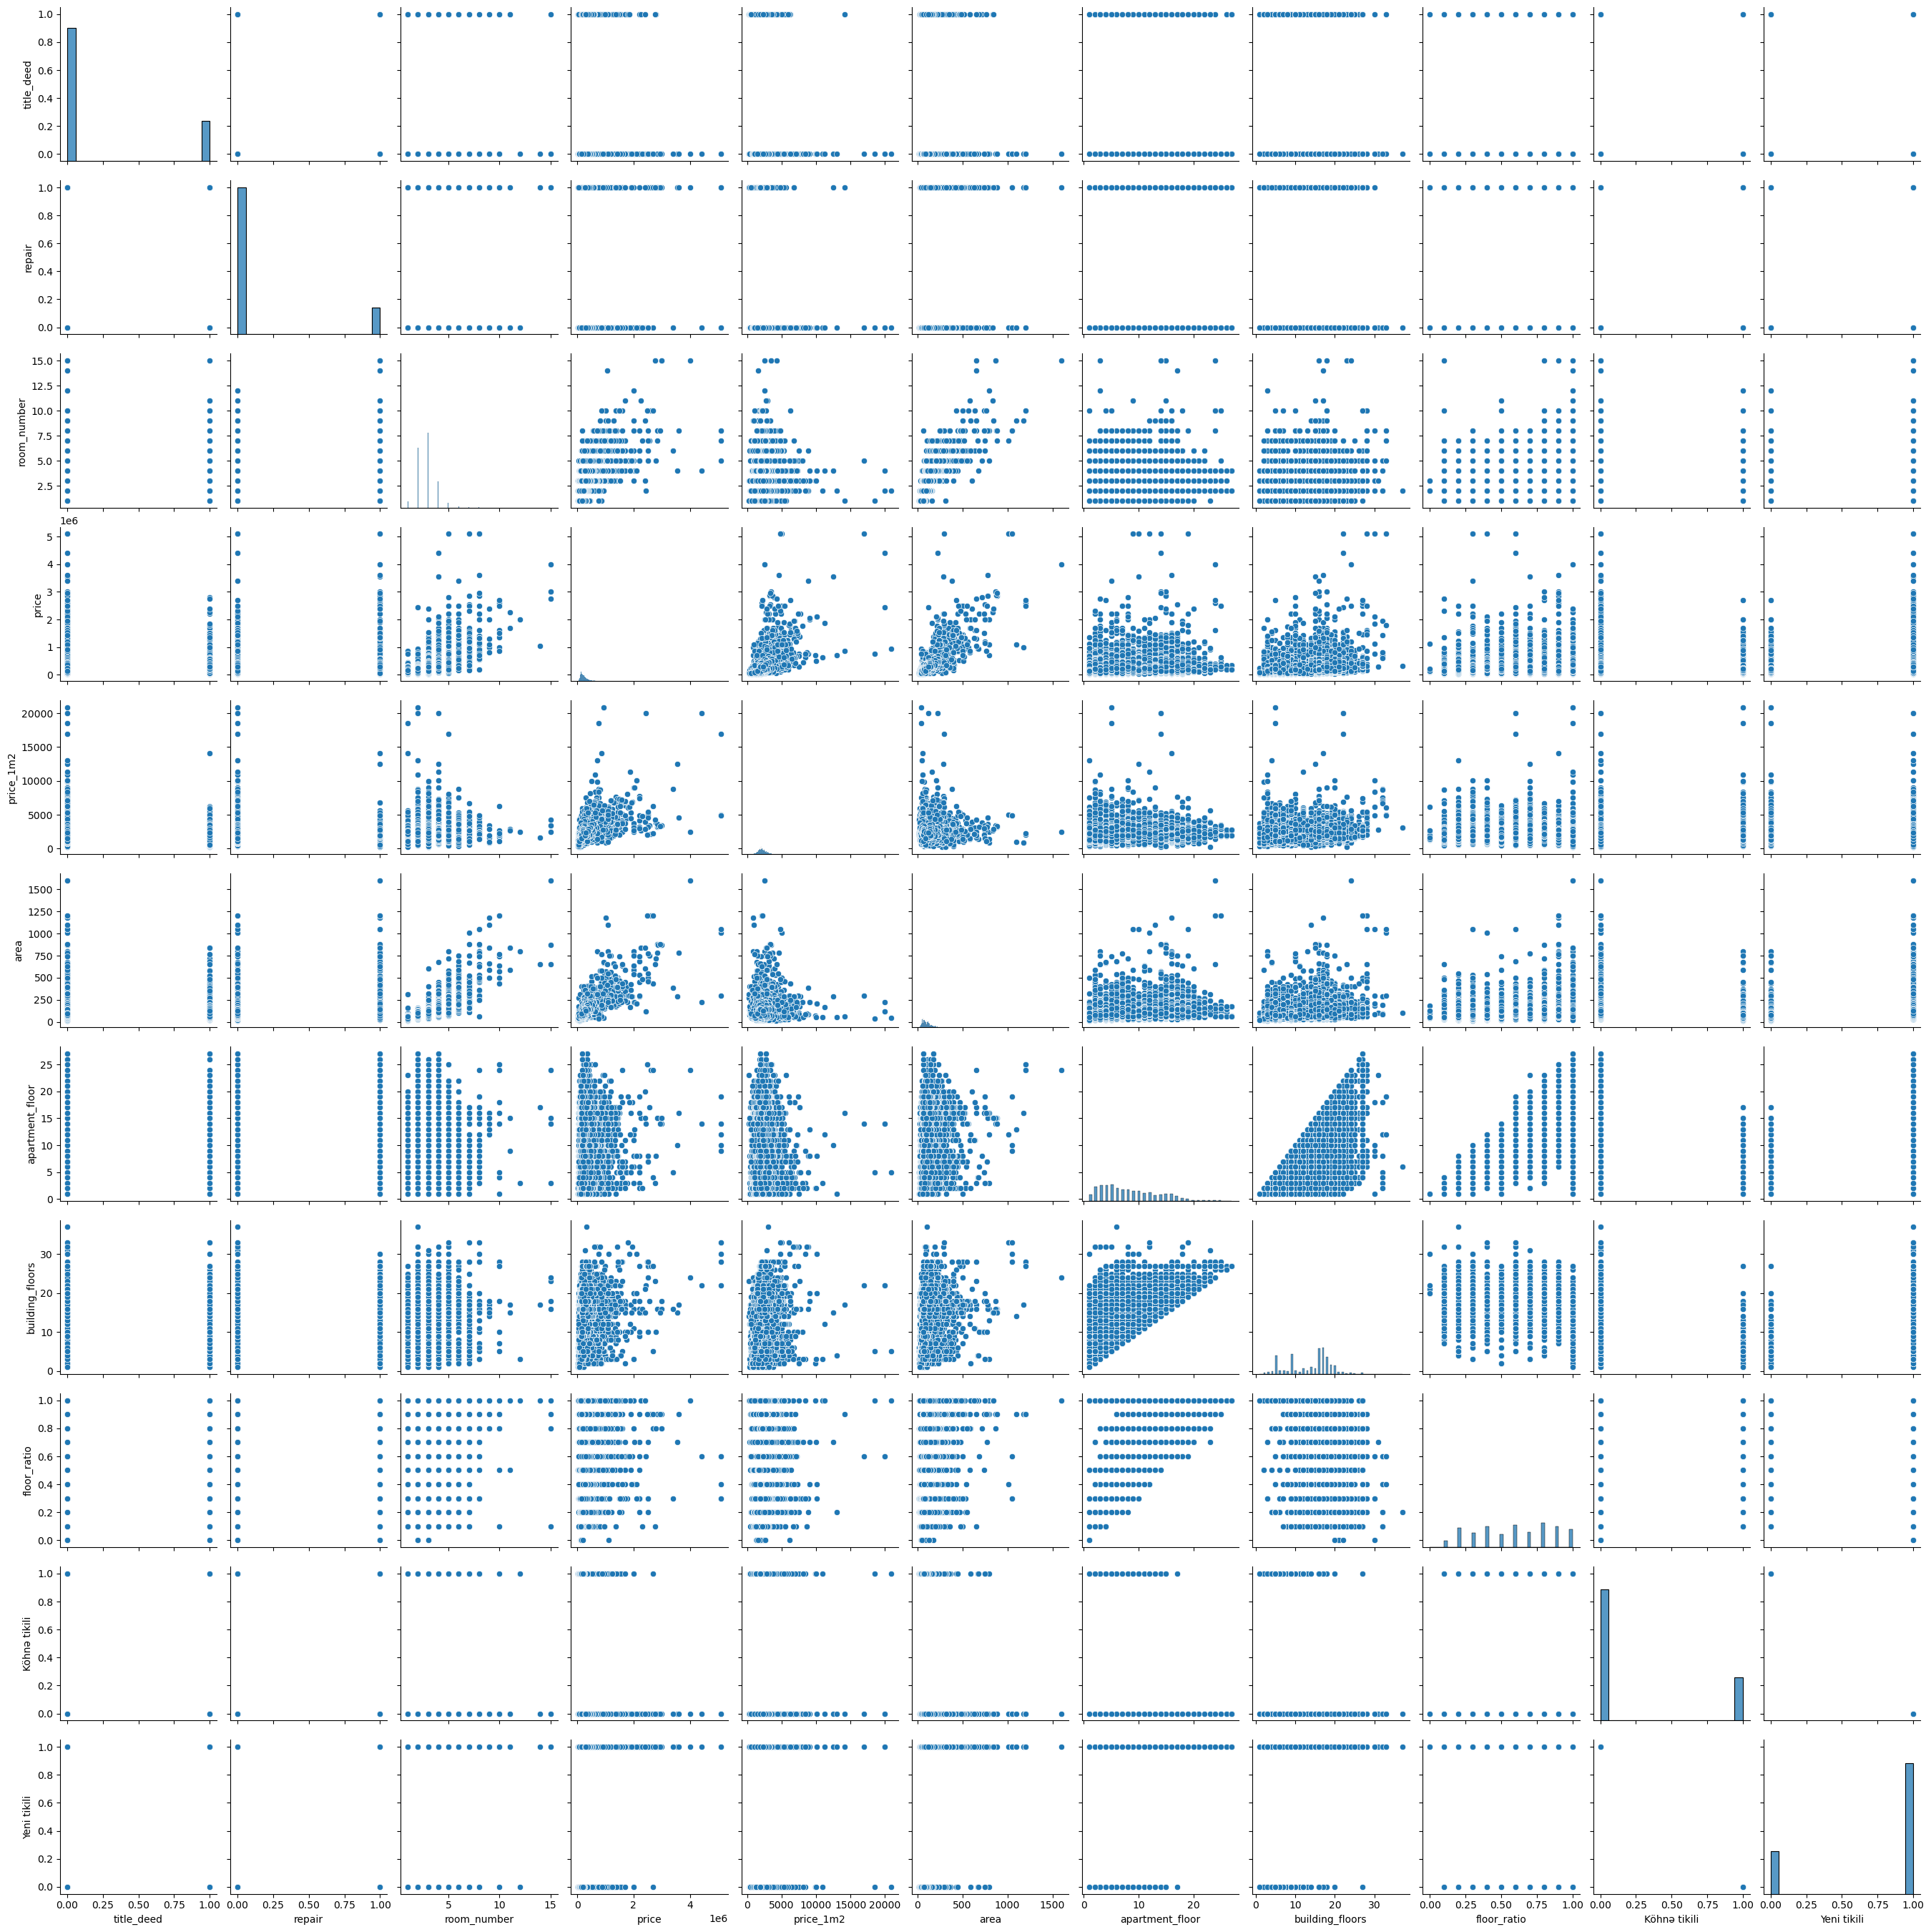

In [87]:
sns.pairplot(cleaned_house_listing)
plt.show()

In [88]:
corr_matrix = cleaned_house_listing.corr()
corr_matrix

,title_deed,repair,room_number,price,price_1m2,area,apartment_floor,building_floors,floor_ratio,Köhnə tikili,Yeni tikili
title_deed,1.000000,0.303769,-0.095680,-0.020795,0.006548,-0.021846,0.087965,0.149315,-0.020413,-0.291994,0.291994
repair,0.303769,1.000000,0.077895,0.125851,-0.085752,0.220081,0.066800,0.107248,-0.009826,-0.177581,0.177581
room_number,-0.095680,0.077895,1.000000,0.601852,-0.020613,0.777099,0.102682,0.123760,0.020703,-0.112018,0.112018
price,-0.020795,0.125851,0.601852,1.000000,0.509587,0.822000,0.157715,0.255004,-0.014648,-0.253284,0.253284
price_1m2,0.006548,-0.085752,-0.020613,0.509587,1.000000,0.059330,-0.002725,0.059555,-0.032492,-0.033870,0.033870
area,-0.021846,0.220081,0.777099,0.822000,0.059330,1.000000,0.223775,0.316161,0.004863,-0.327153,0.327153
apartment_floor,0.087965,0.066800,0.102682,0.157715,-0.002725,0.223775,1.000000,0.619253,0.653633,-0.451820,0.451820
building_floors,0.149315,0.107248,0.123760,0.255004,0.059555,0.316161,0.619253,1.000000,-0.102104,-0.743225,0.743225
floor_ratio,-0.020413,-0.009826,0.020703,-0.014648,-0.032492,0.004863,0.653633,-0.102104,1.000000,0.090895,-0.090895
Köhnə tikili,-0.291994,-0.177581,-0.112018,-0.253284,-0.033870,-0.327153,-0.451820,-0.743225,0.090895,1.000000,-1.000000


We could drop `floor_ratio` and `title_deed` as they are very poorly negatively correlated with `price`. But we will still use all and 
may be later drop and compair performance.

## Modeling

In [91]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score, KFold

In [92]:
y = cleaned_house_listing['price']
y[0:10]

0    137000.0
1    183000.0
2    145000.0
3    190000.0
4    294000.0
5     87000.0
6    550000.0
7    125000.0
8    150000.0
9     62000.0
Name: price, dtype: float64

In [93]:
X = cleaned_house_listing.drop('price', axis='columns')
X.head()

,title_deed,repair,room_number,price_1m2,area,apartment_floor,building_floors,floor_ratio,Köhnə tikili,Yeni tikili
0,0,0,3.0,2630.0,52.0,7.0,9.0,0.8,1,0
1,1,0,2.0,1790.0,102.0,2.0,17.0,0.1,0,1
2,0,0,2.0,2230.0,65.0,6.0,9.0,0.7,1,0
3,0,0,3.0,2000.0,95.0,4.0,9.0,0.4,1,0
4,0,1,3.0,1550.0,190.0,6.0,16.0,0.4,0,1


We split our dataset into training and test datasets

In [95]:
# Train 75% and Test 25% of dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75, random_state=0)

In [96]:
# Scale data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [97]:
reg_model = LinearRegression() 

In [98]:
reg_model.fit(X_train_scaled, y_train) # Train our model

LinearRegression()

In [99]:
y_predicted = reg_model.predict(X_test_scaled) # Predict our test data
y_predicted[0:10]

array([ 79650.80665902, -42904.6726506 , 136679.78279268,  22997.29869965,
       263134.65894066,  52530.05340373, 245095.88598981, 170057.0902162 ,
       129601.01494827, 327147.46601571])

## Model evaluation and Validation

In [101]:
reg_scores = reg_model.score(X_test_scaled, y_test) # Score our model
reg_scores

0.9049772366877692

In [102]:
kf = KFold(shuffle=True, n_splits=5) # We want to apply shuffling, so we use K-Fold.

In [103]:
scores = cross_val_score(reg_model, X, y, cv=kf) 
scores

array([0.90389412, 0.86746281, 0.9048741 , 0.87930801, 0.88750675])

In [104]:
scores.mean()

0.8886091586311403

In [105]:
# Perform cross-validation using negative MSE (lower MSE is better)
mse_scores = cross_val_score(reg_model, X, y, cv=kf, scoring='neg_mean_squared_error')

# Since the result is negative, multiply by -1 to get positive MSE values
mse_scores = -mse_scores
mse_scores

array([3.06521532e+09, 6.25918878e+09, 3.44524677e+09, 2.69417168e+09,
       4.89448625e+09])

In [106]:
mse_scores.mean()

4071661759.0657473

We can see that our model's performance for MSE is poor. If we compare the mean of MSE, it is war off with our minimum and maximum values from our dataset EDA. 
This could suggest outliers.

In [108]:
mae_scores = cross_val_score(reg_model, X, y, cv=kf, scoring='neg_mean_absolute_error')
mae_scores = -mae_scores
mae_scores

array([26281.89624862, 25936.67620071, 27151.79862641, 26346.03980306,
       27414.31454853])

In [109]:
mae_scores.mean()

26626.145085464697

MAE produces better results which shows majority of the predicted values are close to actual values.

## Results

Let's visualize how well our model peforms by comparing the true and predicted prices

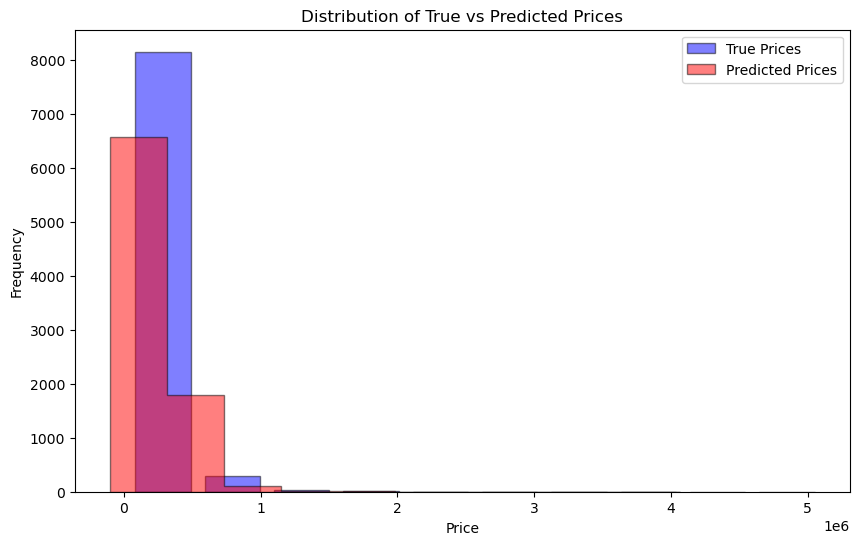

In [113]:
# Number of bins and bin width
n_bins = 10
bin_width = (max(np.max(y_test), np.max(y_predicted)) - min(np.min(y_test), np.min(y_predicted))) / n_bins

# Plotting side-by-side histograms for true vs predicted prices
plt.figure(figsize=(10, 6))

# Plotting the true prices histogram
plt.hist(y_test, bins=n_bins, alpha=0.5, label='True Prices', color='blue', edgecolor='black', align='mid', rwidth=0.8)

# Plotting the predicted prices histogram, with a small offset to avoid overlap
plt.hist(y_predicted, bins=n_bins, alpha=0.5, label='Predicted Prices', color='red', edgecolor='black', align='mid', rwidth=0.8, histtype='stepfilled')

# Labels and title
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.legend()
plt.title('Distribution of True vs Predicted Prices')

plt.show()
plt.close()